# Dimensionality reduction using LSA

In this notebook, I will be using the 20 Newsgroups dataset to show how you can apply some of the techniques we've learned in lessons on text data. 

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from sklearn.linear_model import LogisticRegression
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD, randomized_svd
import string

import warnings
warnings.filterwarnings('ignore')

## Extract, Transform and Load our text data

In [2]:
from sklearn.datasets import fetch_20newsgroups

In [3]:
X_train, y_train = fetch_20newsgroups(subset='train', return_X_y=True)
X_test, y_test = fetch_20newsgroups(subset='test', return_X_y=True)


In [4]:
X_train[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

## Cleaning and Preprocessing

The cleaning of text data is often a very different beast from cleaning of numerical data. It's quite often that you'll find yourself having prepared your vectorizer, you model and are ready to gridsearch and extract features, only to find that the most important features in cluster x is the string "___" ... so you go back...

The function below came about as a result of me realizing that I needed to remove website URLs, numbers and emails from the dataset. 

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
stop_words = list(set(stopwords.words("english")))
stop_words += list(string.punctuation)
stop_words += ['__', '___']

# Uncomment and run the 3 lines below if you haven't got these packages already
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

def rmv_emails_websites(string):
    new_str = re.sub(r"\S+@\S+", '', string)
    new_str = re.sub(r"\S+.co\S+", '', new_str)
    new_str = re.sub(r"\S+.ed\S+", '', new_str)
    new_str = re.sub(r"[0-9]+", '', new_str)
    return new_str

In [6]:
X_train = list(map(rmv_emails_websites, X_train))
X_test  = list(map(rmv_emails_websites, X_test))

In [7]:
X_train[0]

"From:  (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: \nOrganization: University of Maryland, College Park\nLines: \n\n I was wondering if anyone out  enlighten me on this car I saw\nthe other day. It was a -door sports car, looked to be from the late s/\nearly s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [8]:
stop_words

['it',
 'up',
 'those',
 'ma',
 'needn',
 'doesn',
 'himself',
 'between',
 't',
 'no',
 'didn',
 'then',
 'their',
 'was',
 'did',
 'most',
 'below',
 "you're",
 'yourself',
 'won',
 'being',
 'few',
 'not',
 'yourselves',
 'he',
 "didn't",
 'during',
 'itself',
 'should',
 'will',
 'which',
 'when',
 'has',
 'the',
 'been',
 'does',
 "mightn't",
 'there',
 'off',
 'ours',
 'be',
 'shouldn',
 'into',
 'a',
 'further',
 "she's",
 'both',
 'an',
 'that',
 'am',
 'again',
 'here',
 'haven',
 'some',
 "doesn't",
 'hasn',
 "hasn't",
 'for',
 'o',
 'ain',
 'weren',
 'how',
 'now',
 'they',
 'from',
 "weren't",
 'same',
 'your',
 "that'll",
 'but',
 'mightn',
 "won't",
 "don't",
 'until',
 'more',
 'have',
 'd',
 "isn't",
 "should've",
 'them',
 'couldn',
 'she',
 'above',
 'against',
 'over',
 'by',
 'in',
 'hadn',
 "you've",
 'so',
 's',
 'before',
 'very',
 "hadn't",
 'you',
 "shan't",
 'such',
 'were',
 'yours',
 'doing',
 'and',
 'll',
 "mustn't",
 'whom',
 'only',
 'this',
 'of',
 'mys

## Vectorizing text data

Below you begin the process of vectorizing your text data since our models work on numbers, not string!
I recommend with any transformation process (especially ones that take time to run) you do them on the first 10 rows of your data and inspect results: are they what you expected to see? Is the shape of the dataframe what you hoped for?

In [9]:
sample_tfidf = TfidfVectorizer(lowercase=True, 
                        stop_words=stop_words, 
                        tokenizer=tokenizer.tokenize,
#                         max_df = 0.8,
                        min_df = 0.1
                       )

In [10]:
sample_sparse = sample_tfidf.fit_transform(X_train[:20])
# sample_sparse.toarray()

In [12]:
sample_exp = pd.DataFrame(sample_sparse.toarray(), 
                        columns=sample_tfidf.get_feature_names())

sample_exp.head()

,able,absolute,acceleration,access,actually,add,addition,agree,almost,already,...,worse,worth,would,writers,writes,writing,wrong,year,years,yet
0,0.0,0.0,0.000000,0.000000,0.00000,0.00000,0.148713,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.122926,0.000000
1,0.0,0.0,0.132307,0.000000,0.00000,0.21873,0.000000,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.000000,0.096939,0.10743,0.00000,0.000000,0.0,0.0,0.000000,...,0.0,0.10743,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.091326,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.156392,...,0.0,0.00000,0.0,0.0,0.092476,0.0,0.0,0.0,0.000000,0.156392


Ok, so we can see that's pretty good. Tfidf has arranged the words alphabetically as columns and our indices represent the documents we passed in.
We can now initialize a tfidf object and fit_transform our train data.

In [13]:
tfidf = TfidfVectorizer(lowercase=True, 
                        stop_words=stop_words, 
                        tokenizer=tokenizer.tokenize,
                        min_df=0.05
                       )
tfidf_train_sparse = tfidf.fit_transform(X_train)
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), 
                        columns=tfidf.get_feature_names())

tfidf_train_df.head()

,able,access,actually,ago,already,also,always,another,anyone,anything,...,works,world,would,writes,wrong,wrote,year,years,yes,yet
0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.220925,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.129397,0.000000,0.000000
1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2,0.0,0.131975,0.121422,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.151604,0.0,...,0.0,0.157113,0.0,0.094068,0.0,0.204027,0.0,0.000000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.0,0.248264,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.108197,0.0,0.000000,0.0,0.000000,0.237686,0.237104


In [14]:
#and now for the test dataset as well
tfidf_test_sparse = tfidf.transform(X_test)
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), 
                        columns=tfidf.get_feature_names())
tfidf_test_df.head()


,able,access,actually,ago,already,also,always,another,anyone,anything,...,works,world,would,writes,wrong,wrote,year,years,yes,yet
0,0.0,0.0,0.0,0.0,0.0,0.148884,0.00000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.199064,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.157172,0.110547,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.143488,0.000000,0.0,0.000000,0.000000,0.315212,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.098632,0.07283,0.0,0.159954,0.065775,...,0.0,0.055256,0.116592,0.033083,0.071852,0.0,0.000000,0.000000,0.000000,0.072499
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.173888,0.000000,0.312335,0.000000,0.0,0.000000,0.196551,0.228710,0.000000


In [15]:
tfidf_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Columns: 241 entries, able to yet
dtypes: float64(241)
memory usage: 20.8 MB


So we now have 1684-dimensional data and both sets transformed. The rest of this notebook will be about the two processes we're illustrating: dimensionality reduction and clustering. These will be done separately. 

## Dimensionality Reduction with SVD (LSA)

### Concept

In simple terms: SVD (Singular Value Decomposition) takes some meaningful data and recreates it in n different parts that each express a different way of looking at the meaning in the data. If you imagine the data as a an idea, there would be *n* different ways of *looking* at that idea, or *n* different ways of *conceptualizing* the data. 

Now the more complex formulation: SVD is a method of dimensionality reduction that maps your data matrix to a matrix of latent features, where each features is supposed to be an important component of your data. We're saying it's "suppose to" because operating on mathematical *assumptions*. This is used in model-based recommendation systems. It is very similar to PSA, except that it operates better on sparse data than PCA does. Another key difference is that PCA performs eigendecomposition (i.e. finding the eigenvectors) on the *correlation* matrix of a datase; SVD performs decomposition directly on the dataset as it is.

When used on text data it is referred to as LSA (Latent Semantic Analysis). I will be referring to this technique as LSA from now on, due to the example chosen, but everything I say here applies to SVD as well.


In [16]:
print('Figure 1 - SVD formula')
print("\n")
Image(filename='img/equation.jpg', width=700, height=700) 

Figure 1 - SVD formula




FileNotFoundError: [Errno 2] No such file or directory: 'img/equation.jpg'

In [17]:
print('Figure 2 - Document Term matrix, our starting point')
print("\n")
Image(filename='img/document_term_matrix.jpg', width=700, height=700, metadata={'title':'Document Term matrix; Figure 1'}) 

Figure 2 - Document Term matrix, our starting point




FileNotFoundError: [Errno 2] No such file or directory: 'img/document_term_matrix.jpg'

##### Intuition
Suppose that we have some table of data, in this case text data, where each row is one document, and each column represents a term. This is the standard way to represent data (in a *document-term matrix*, as shown in Figure 2). 

Now the different documents will have different topics, let's say it's all political articles and there are 3 topics: foreign policy, elections and reform. Let's say that there are articles squarely belonging to each category, some that are in two and some that belong to all 3 categories. We could plot a table where we have each row being a different document (a news article) and each column being a different topic. In the cells we would have a different numbers that indicated how strongly that document belonged to the particular topic (see Figure 3). 


Figure 3 - our imagined Document Topic matrix




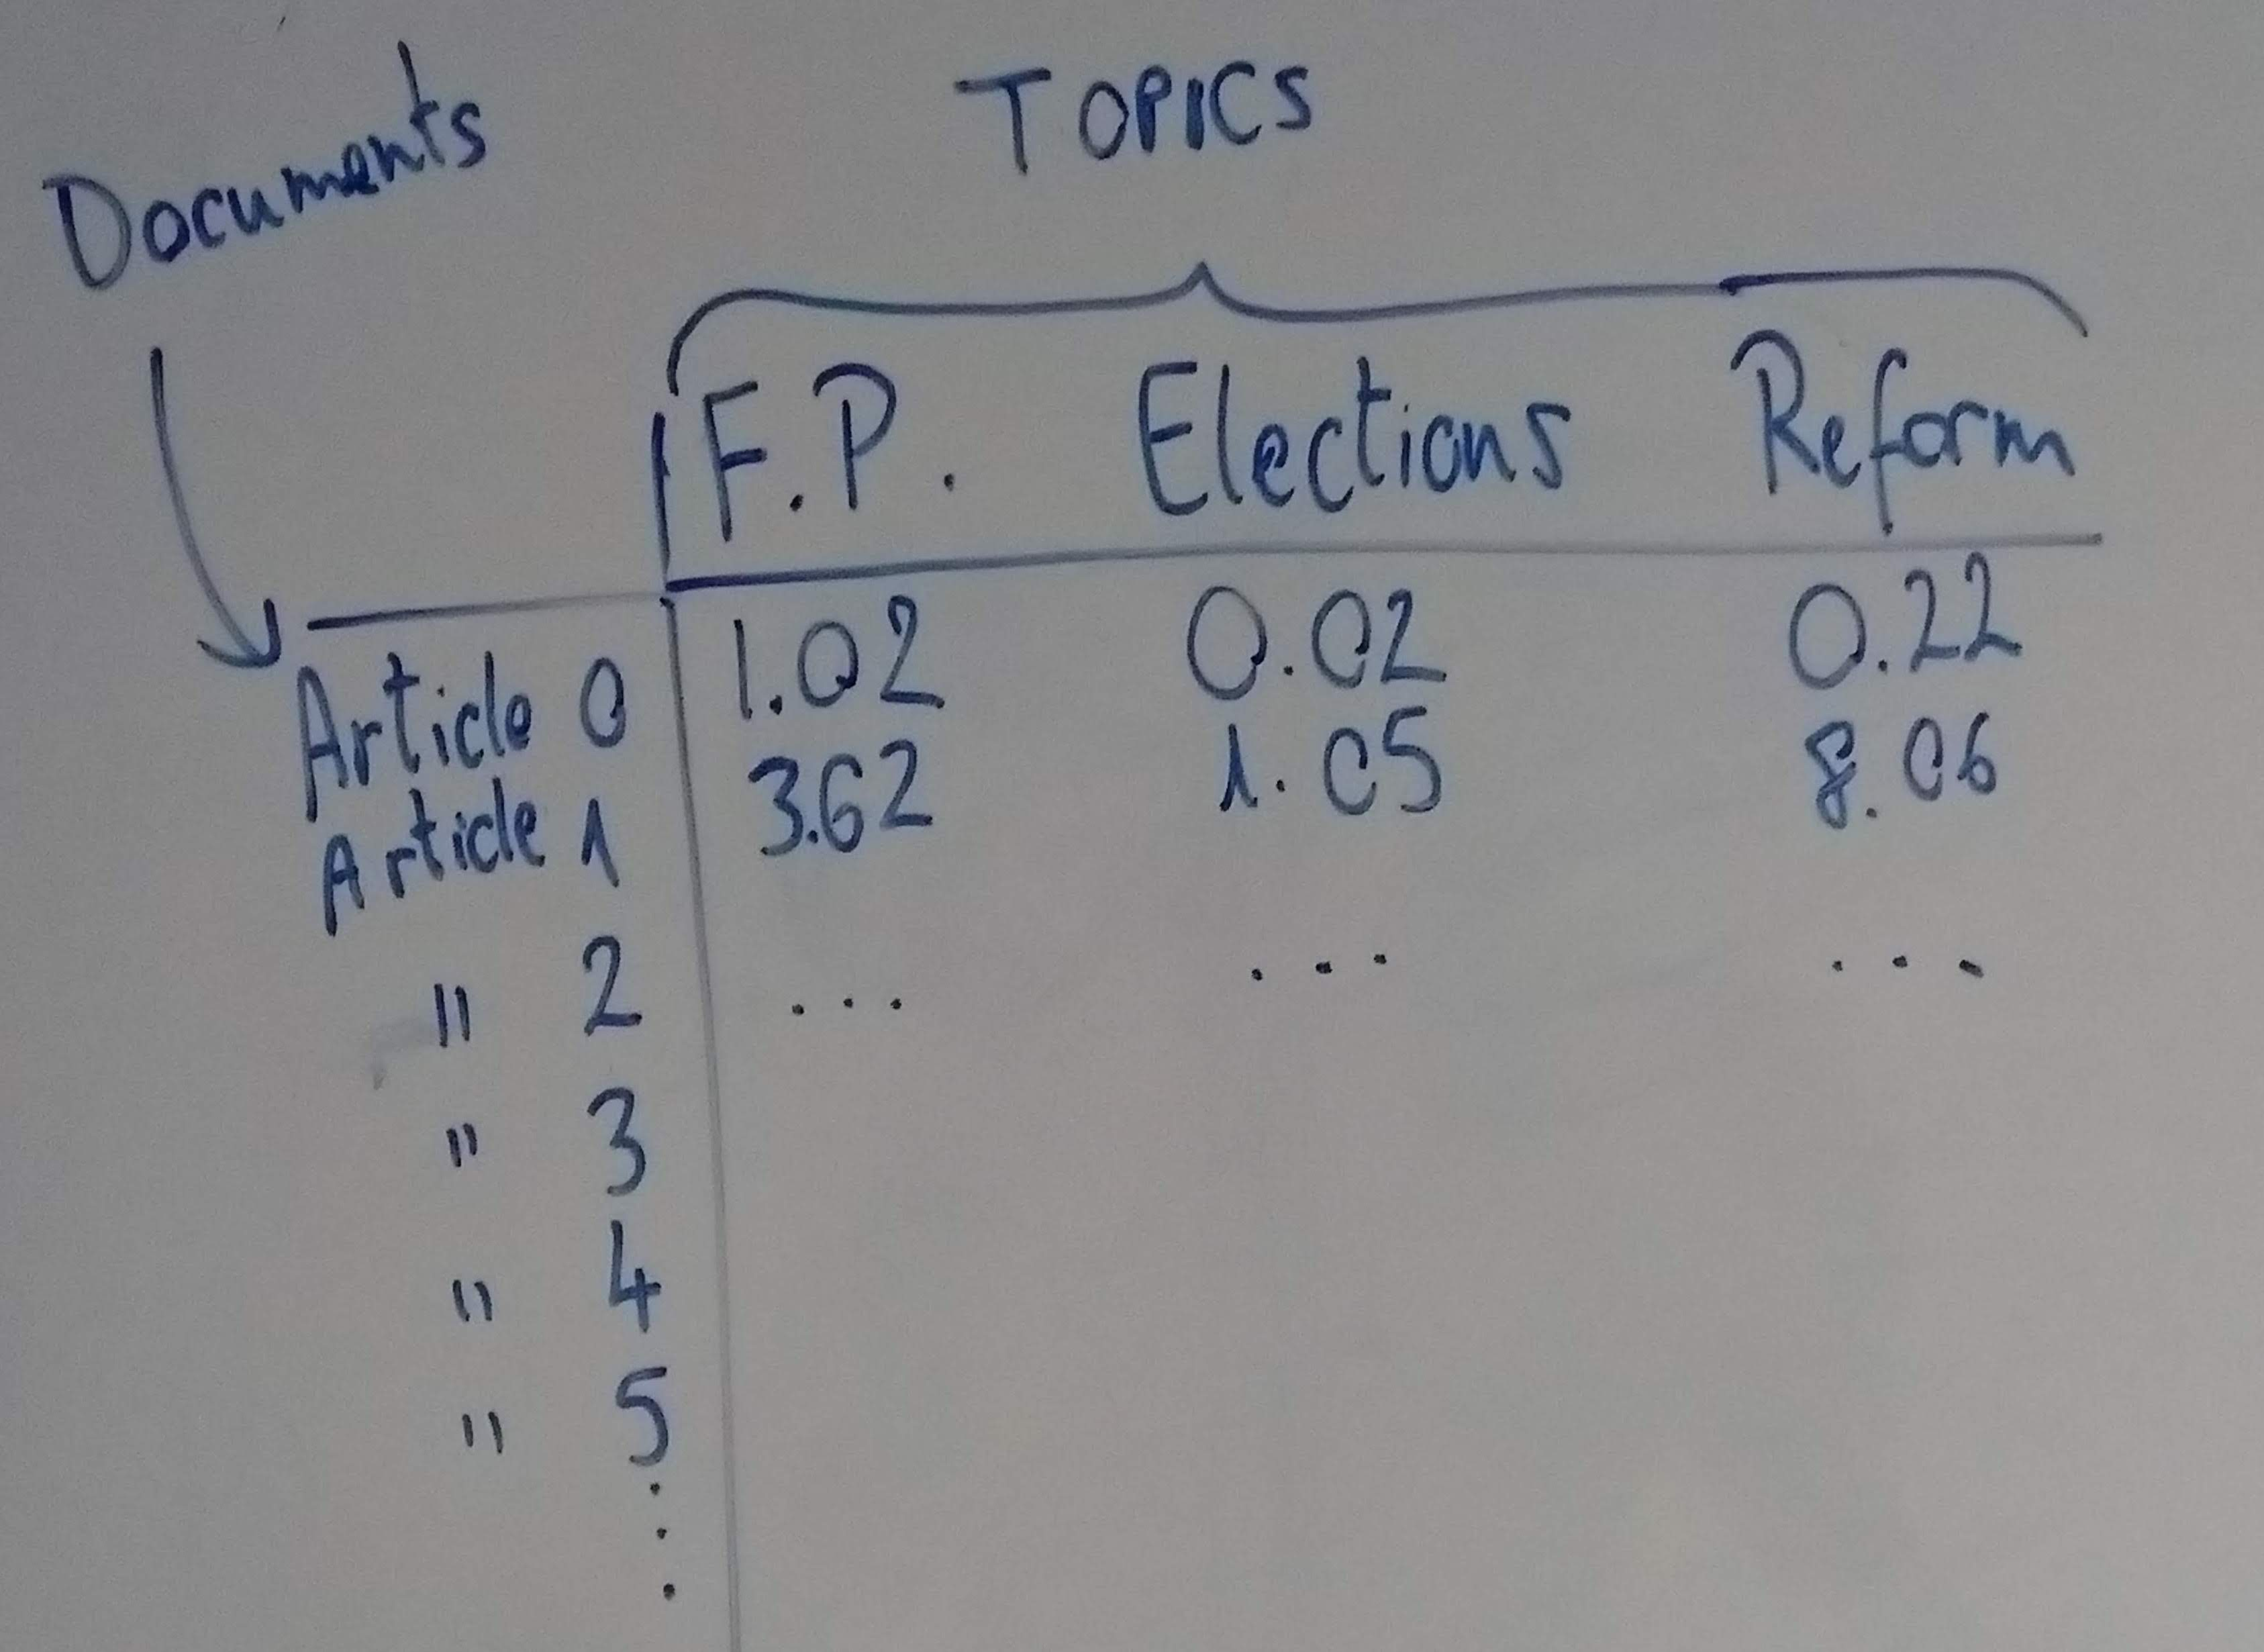

In [24]:
print('Figure 3 - our imagined Document Topic matrix')
print("\n")
Image(filename='img/document_topic.jpg', width=700, height=700) 


Now if we shift our attention conceptually to the **topics** themselves, we should ask ourselves the following question:
- Do we expect certain words to turn up more often in either of these topics? 

If we're looking at foreing policy, we might see terms like "Middle East", "EU", "embassies". For elections it might be "ballot", "candidates", "party"; and for reform we might see "bill", "ammendment" or "corruption". So, if we plotted these topics and these terms in a different table, where the rows are the terms, we would see scores plotted for each term according to which topic it most strongly belonged to. Naturally there will be terms that feature in all three documents ("prime minister", "Parliament", "decision") and these terms will have scores across all 3 columns that reflect how much they belong to either category - the higher the number, the greater its affiliation to that topic. So, our second table (Figure 4) consists of terms and topics. 



Figure 4 - Term-Topic matrix: what words go with which topic; Note that we'll be flipping this matrix




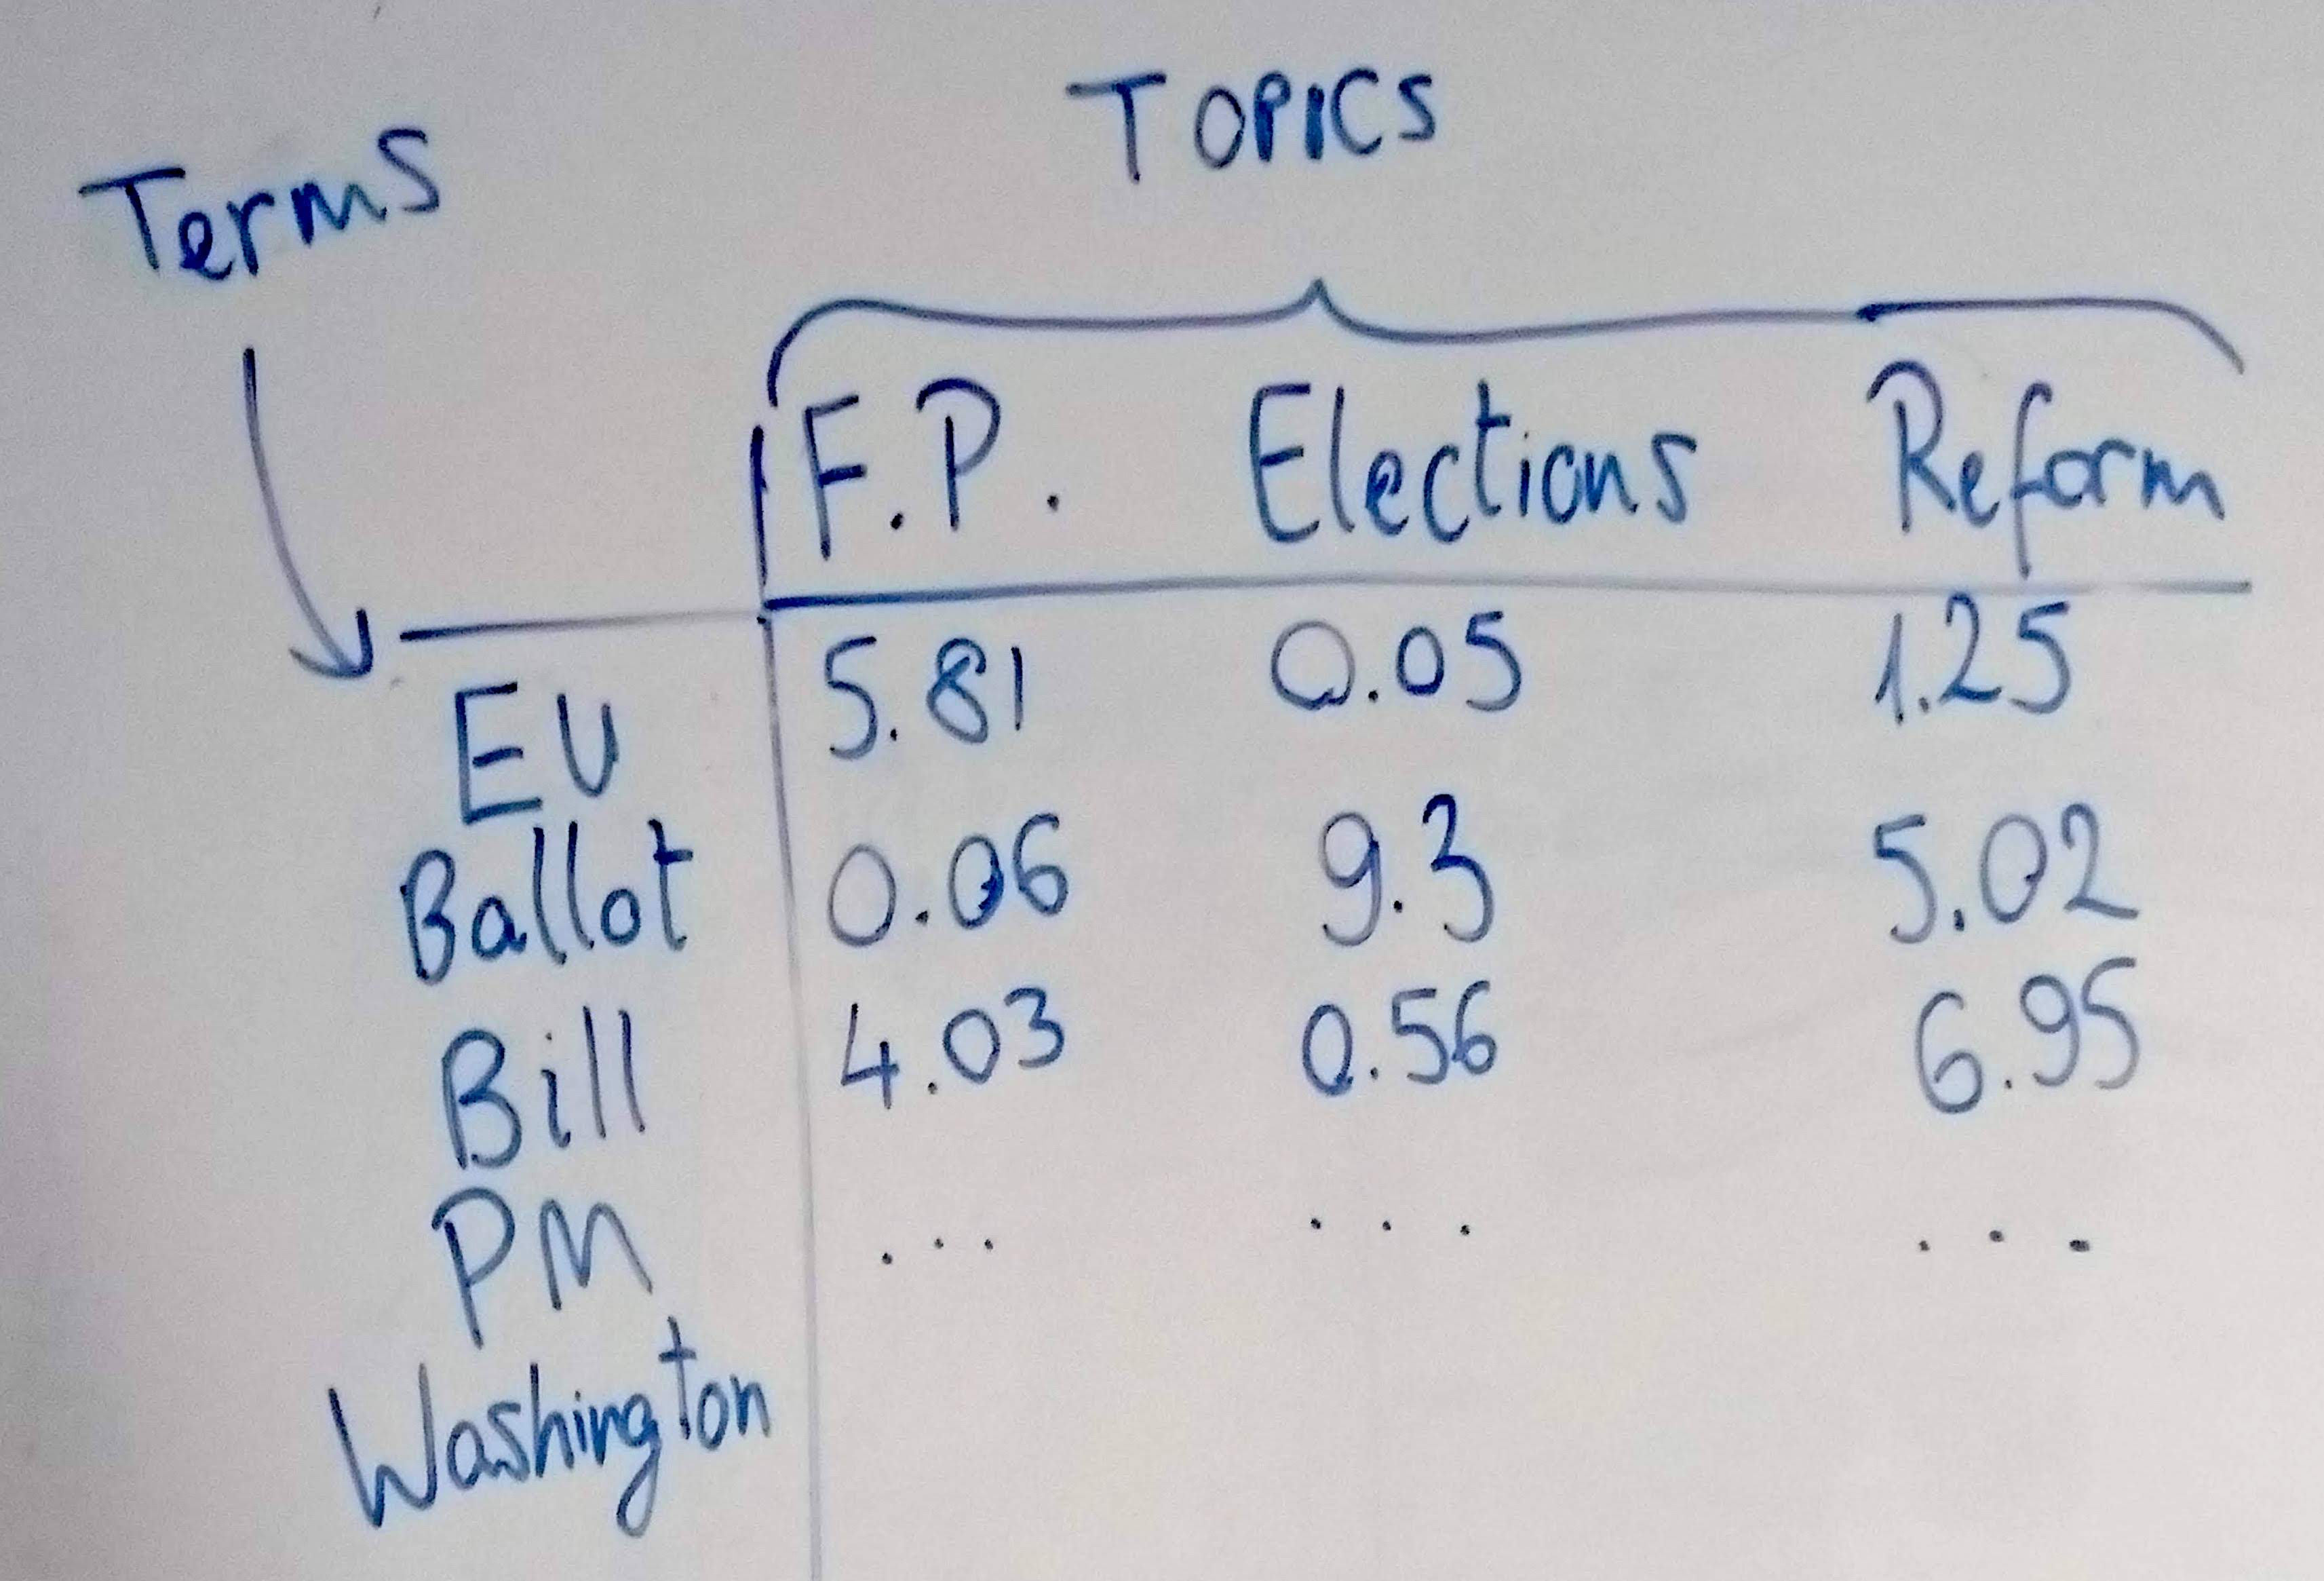

In [25]:
print('Figure 4 - Term-Topic matrix: what words go with which topic; Note that we\'ll be flipping this matrix')
print("\n")
Image(filename='img/term_topic.jpg', width=700, height=700) 


Now the last component is a bit trickier to explain as a table. It's actually a set of numbers, one for each of our topics. What do the numbers represent? They represent how much each of the topics *explains* our data. 

How do I mean "explain"? Well, suppose that actually, "reform" wasn't really a salient topic across our articles, and the majority of the articles fit in far more comfortably in the "foreign policy" and "elections". Thus "reform" would get a really low number in this set, lower than the other two. An alternative is that maybe all three numbers are actually quite low and we actually should have had four or more topics - we find out later that a lot of our articles were actually concerned with economics! By sticking to just three topics we've been denying ourselves the chance to get a more detailed and precise look at our data. The technical name for this array of numbers is the "singular values".

Figure 5 - Topic importance - the Singular Values




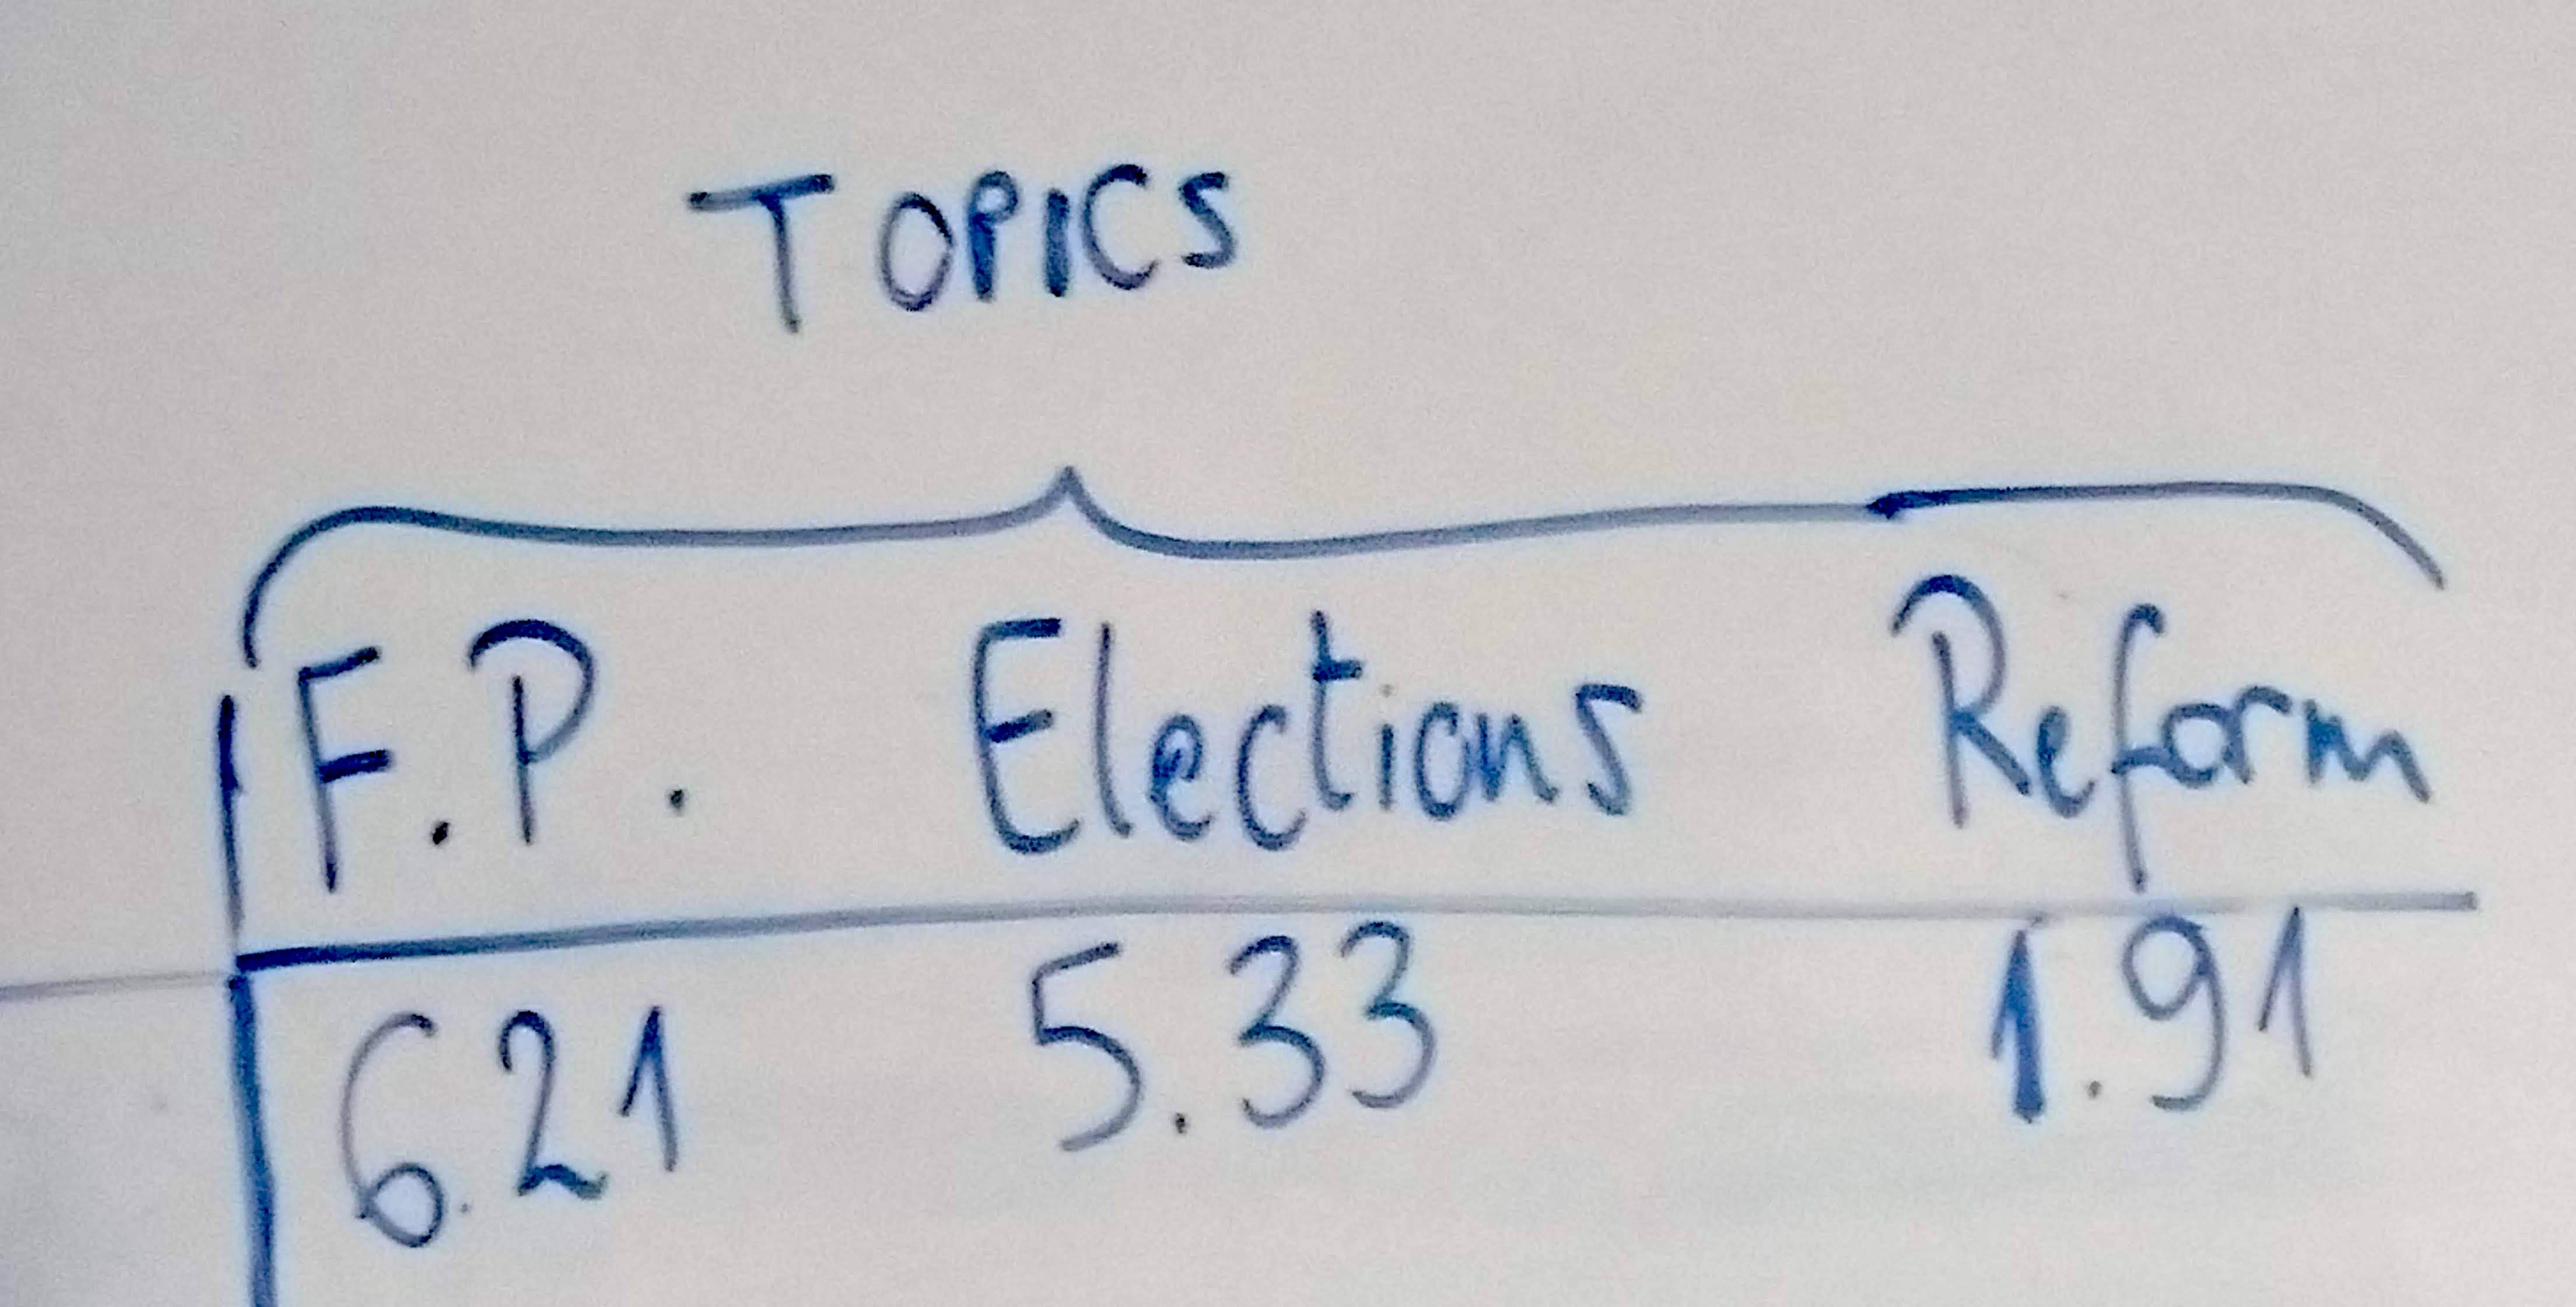

In [26]:
print('Figure 5 - Topic importance - the Singular Values')
print("\n")
Image(filename='img/singular_values.jpg', width=350, height=350) 

Now that's the intuition so far. You'll notice that our two tables have one thing in commont (the documents / articles) and all three of them have one thing in common - the topics, or some representation of them. When we perform LSA, we're normally trying to retrieve the first table, the documents to topics one. 
Now let's explain how this is a dimensionality reduction technique. It's easier to see the merits if we specify a number of documents and topics. 
Suppose we had 100 articles and 10'000 different terms (just think of how many unique words there would be all those articles, from "ammendment" to "zealous"!). In our original document-term matrix that's 100 rows and 10'000 columns. 
When we start to break our data down into the 3 components, we can actually choose the number of topics - we could actually choose for there to be 10'000 different topics, if we genuinely thought there were 10'000 topics present in this corpus. However, we could probably represent the data with far fewer topics, let's say the 3 we originally talked about. That means that in our document-topic table, we'd slash about *99'997 columns*, and in our term-topic table, we'd do the same. In Figure 6 the clipped columns and rows are shown as hashed rectangles. M is the original document-term table; U is the document-topic table, ${\Sigma}$ is the array of singular values and $V{^T}$ is the document-topic table, but flipped on its diagonal (I'll explain why in the math section).

Figure 6 - the hashed parts are the bits we discard




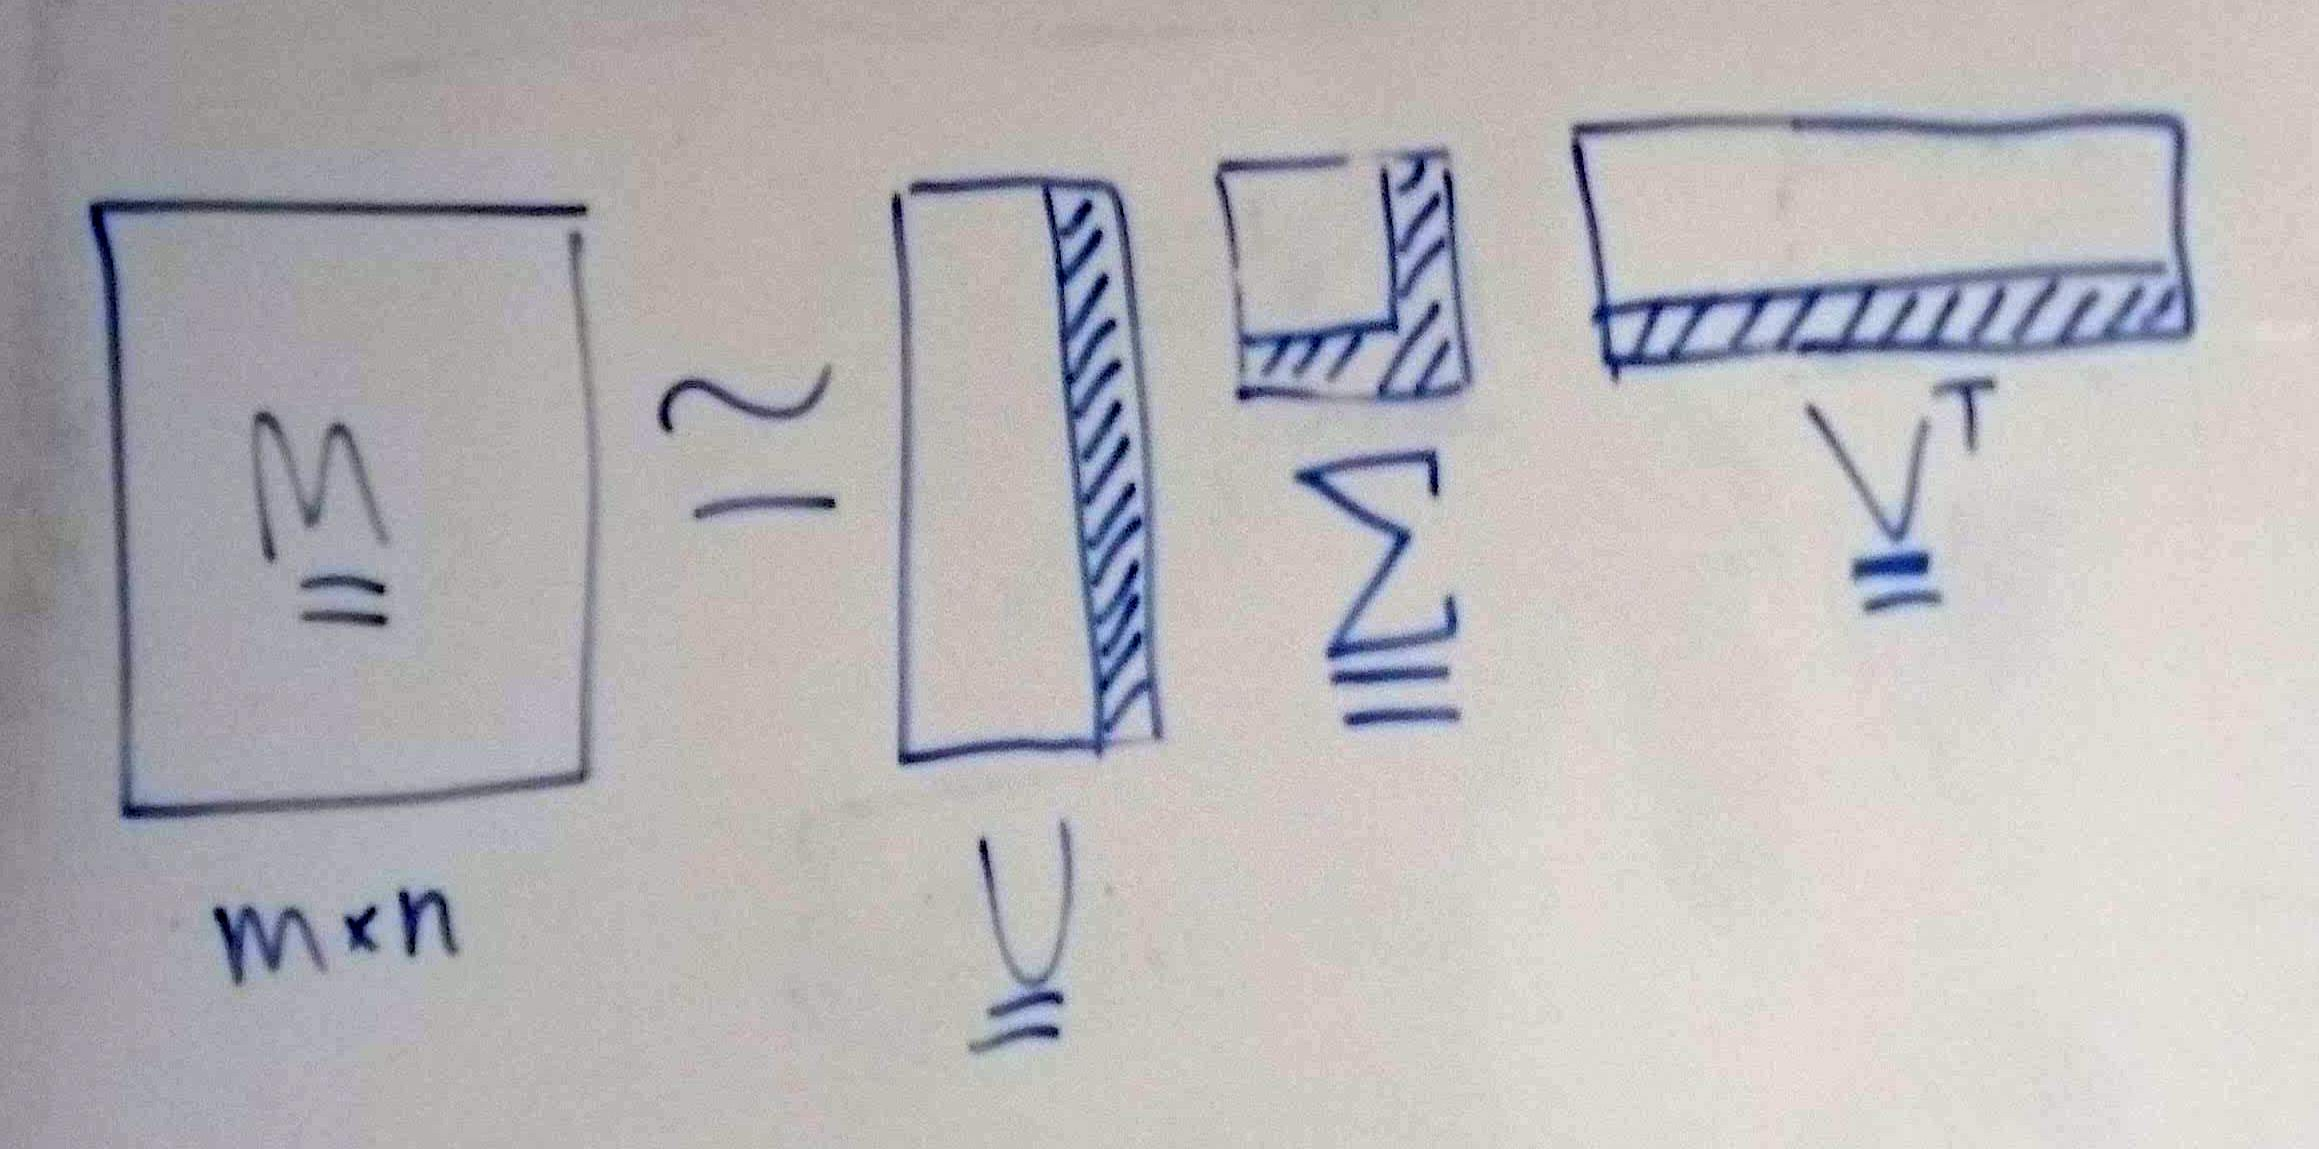

In [27]:
print('Figure 6 - the hashed parts are the bits we discard')
print("\n")
Image(filename='img/matrices_trunc.jpg', width=500, height=400) 

As for the set of numbers denoting topic importance, from a set of 10'000 numbers, each number getting smaller and smaller as it corresponds to a less important topic, we cut down to only 3 numbers, for our 3 remaining topics.
This is why the python implementation for LSA is called *Truncated* SVD by the way: we're cutting off part of our table, but we'll get to the maths in a bit. 

Now, if we take our new, truncated tables, when we combine them together (mathematically this will just be matrix multiplication), we don't get the full dataset back, BUT we get a *lower-dimensional* representation of the dataset - this is exactly what we wanted. It's as if we've compressed the data and now we're seeing how much of the original information has been preserved. 

Of course, we don't just want to return to the original dataset: we now have 3 lower-dimensional components we can use. In the code and maths parts we'll go through which one we actually take forward. In brief, once we've truncated the tables (matrices), the product we'll be getting out is the document-topic table (U) *times* the singular values ( ${\Sigma}$ ). We could intuitively interpret this product as something like "a table showing how much each document belongs to each topic *weighted by* the importance of the topic". 

### Maths
For the maths, I'll be going through two different interpretations of SVD: first the general geometric decomposition that you can use with a real square matrix M and second the separable-models decomposition which is more pertinent to our example. 

We will be **factorizing** this matrix into constituent matrices. When I say factorizing this is essentially the same as when we're taking a number and representing it its factors, which when multiplied together, give us the original number, e.g. $ A = B * C * D $

This is also why it's called Singular Value **Decomposition** - we're *decomposing* it into its constituent parts. 

#### General geometric decomposition 







Now that extra dimension that wasn't available to us on the left-hand side, the *r* dimension, is the amount of *latent concepts*. Generally we're trying to represent our matrix as components that have one of their axes being this set of components. You will also note that, based on dimensions, the multiplication of the 3 matrices (when V is transposed) will lead us back to the shape of our original matrix, the *r* dimension effectively dissappearing. 

What matters in understanding the math is not the algebraic algorithm by which each number in U, V and ${\Sigma}$ is determined, **but** the mathematical properties of these products and how they relate to each other. 

First of all, it's important to consider first what a matrix actually is and what it can be thought of - a transformation on vector space.
In the top left corner of Figure 7 we have two perpendicular vectors. If we have only two variables to start with then the feature space (the data that we're looking at) can be plotted anywhere in this space that is described by these two **basis** vectors. Now moving to the right in our diagram, the matrix M is applied to this vector space and this transforms it into the new, transformed space in our top right corner. In the diagram below the geometric effect of M would be referred to as "shearing" the vector space; the two vectors ${\sigma_{1}}$ and ${\sigma_{2}}$ are actually our singular values plotted in this space. 

Now, just like with geometric transformations of points that you may remember from school, we can reconsider this transformation M as three separate transformations:
1. The rotation (or reflection) caused by $V^{*}$. Note that $V^{*} = V^{T}$ as V is a real unitary matrix, so the complex conjugate of V is the same as its transpose. In vector terms, the transformation by V or $V^{*}$ keeps the length of the basis vectors the same;
2. ${\Sigma}$ has the effect of stretching or compressing all coordinate points along the values of its singular values. Imagine our disc in the bottom left corner as we squeeze it vertically down in the direction of ${\sigma_{2}}$ and stretch it horizontally along the direction of ${\sigma_{1}}$. These two singular values now can be pictured as the major and minor semi-axes of an ellipse. You can of course generalize this to n-dimensions.
3. Lastly applying U rotates (or reflects) our feature space. We've arrived at the same output as a transformation directly from M. 

I also recommend the excellent Wikipedia entry on SVD as it has a particularly good explanation and GIF of the process (https://en.wikipedia.org/wiki/Singular_value_decomposition).

Figure 7
Source: Wikipedia: Singular Value Decomposition; link: https://commons.wikimedia.org/wiki/File:Singular-Value-Decomposition.svg#filelinks; Author : Georg-Johann




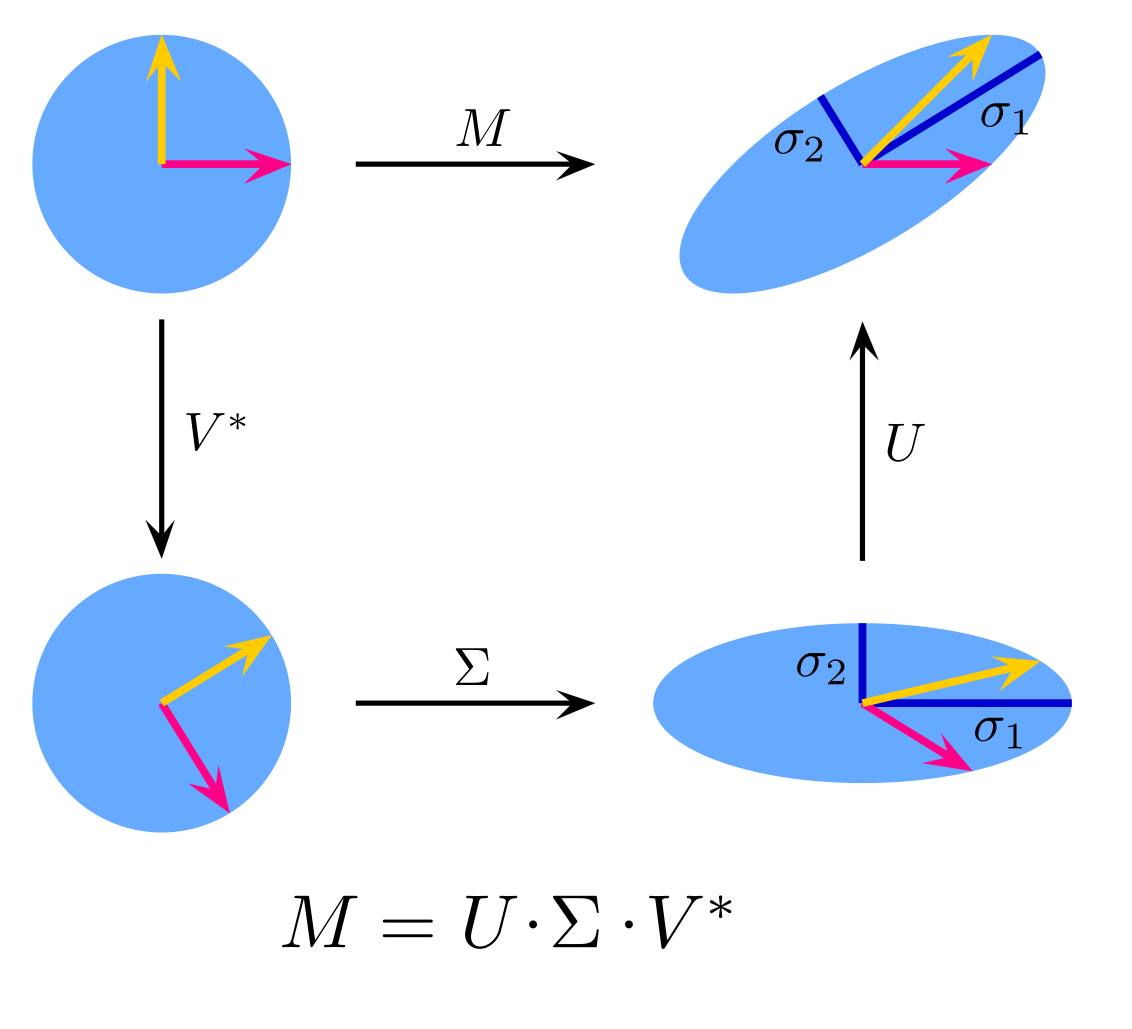

In [28]:
print('Figure 7')
print("Source: Wikipedia: Singular Value Decomposition; link: https://commons.wikimedia.org/wiki/File:Singular-Value-Decomposition.svg#filelinks; Author : Georg-Johann")
print("\n")
Image(filename='img/svd_wikipedia.png', width=500, height=400) 

So, in other words, where x is a column vector:

#### $$ \underline{\underline{M}} \underline{x} = \underline{\underline{U}} * \underline{\underline{\Sigma}} * \underline{\underline{V}} ^{T} \underline{x} $$

One of the properties of the matrices U and $V^{*}$ is that they're unitary, we can say that the columns of both of these matrices form two sets of orthonormal basis vectors. I.e. the column vectors you can get from U would form their own coordinate space, such that if there were two columns: $U_{1}$ and $U_{2}$, you could write out all of the coordinates of the space as combinations of $U_{1}$ and $U_{2}$. The same applies to the columns of V, $V_{1}$ and $V_{2}$, and this would generalize to n-dimensions (you'd have n-columns). 


### Separable Models decomposition

Our matrix M can be broken down into a weighted sum of separable matrices, as shown below. 

### $$ \underline{\underline{M}} = \sum_{i} \underline{\underline{A}}_{i} = \sum_{i} {\sigma}_{i}\underline{u}_{i} {\otimes} \underline{v}_{i}^T  $$

The matrices $A_{i}$ are said to be separable because they can be decomposed into the outer product of two vectors, weighted by the singular value ${\sigma}$. Calculating the outer product of two vectors with shapes (m,) and (n,) would give us a matrix with a shape (m,n). In other words, every possible product of any two numbers in the two vectors is computed and placed in the new matrix. The singular value not only weights the sum but orders it as well, since singular values are arranged in descending order, so that the first singular value is always the highest one. 

In Figure 8 you can see how you could visualize this. Previously we had the tall U, the square ${\Sigma}$ and the long $V^{T}$ matrices. Now you can picture taking the first vertical slice from U, weighting (multiplying) all its values by the first singular value and then, by doing an outer product with the first horizontal slice of $V^{T}$, creating a new matrix with the dimensions of those slices. Then we add those products together and we get M. Or, if we don't do the full sum but only complete it partially, we get the truncated version. 

Figure 8




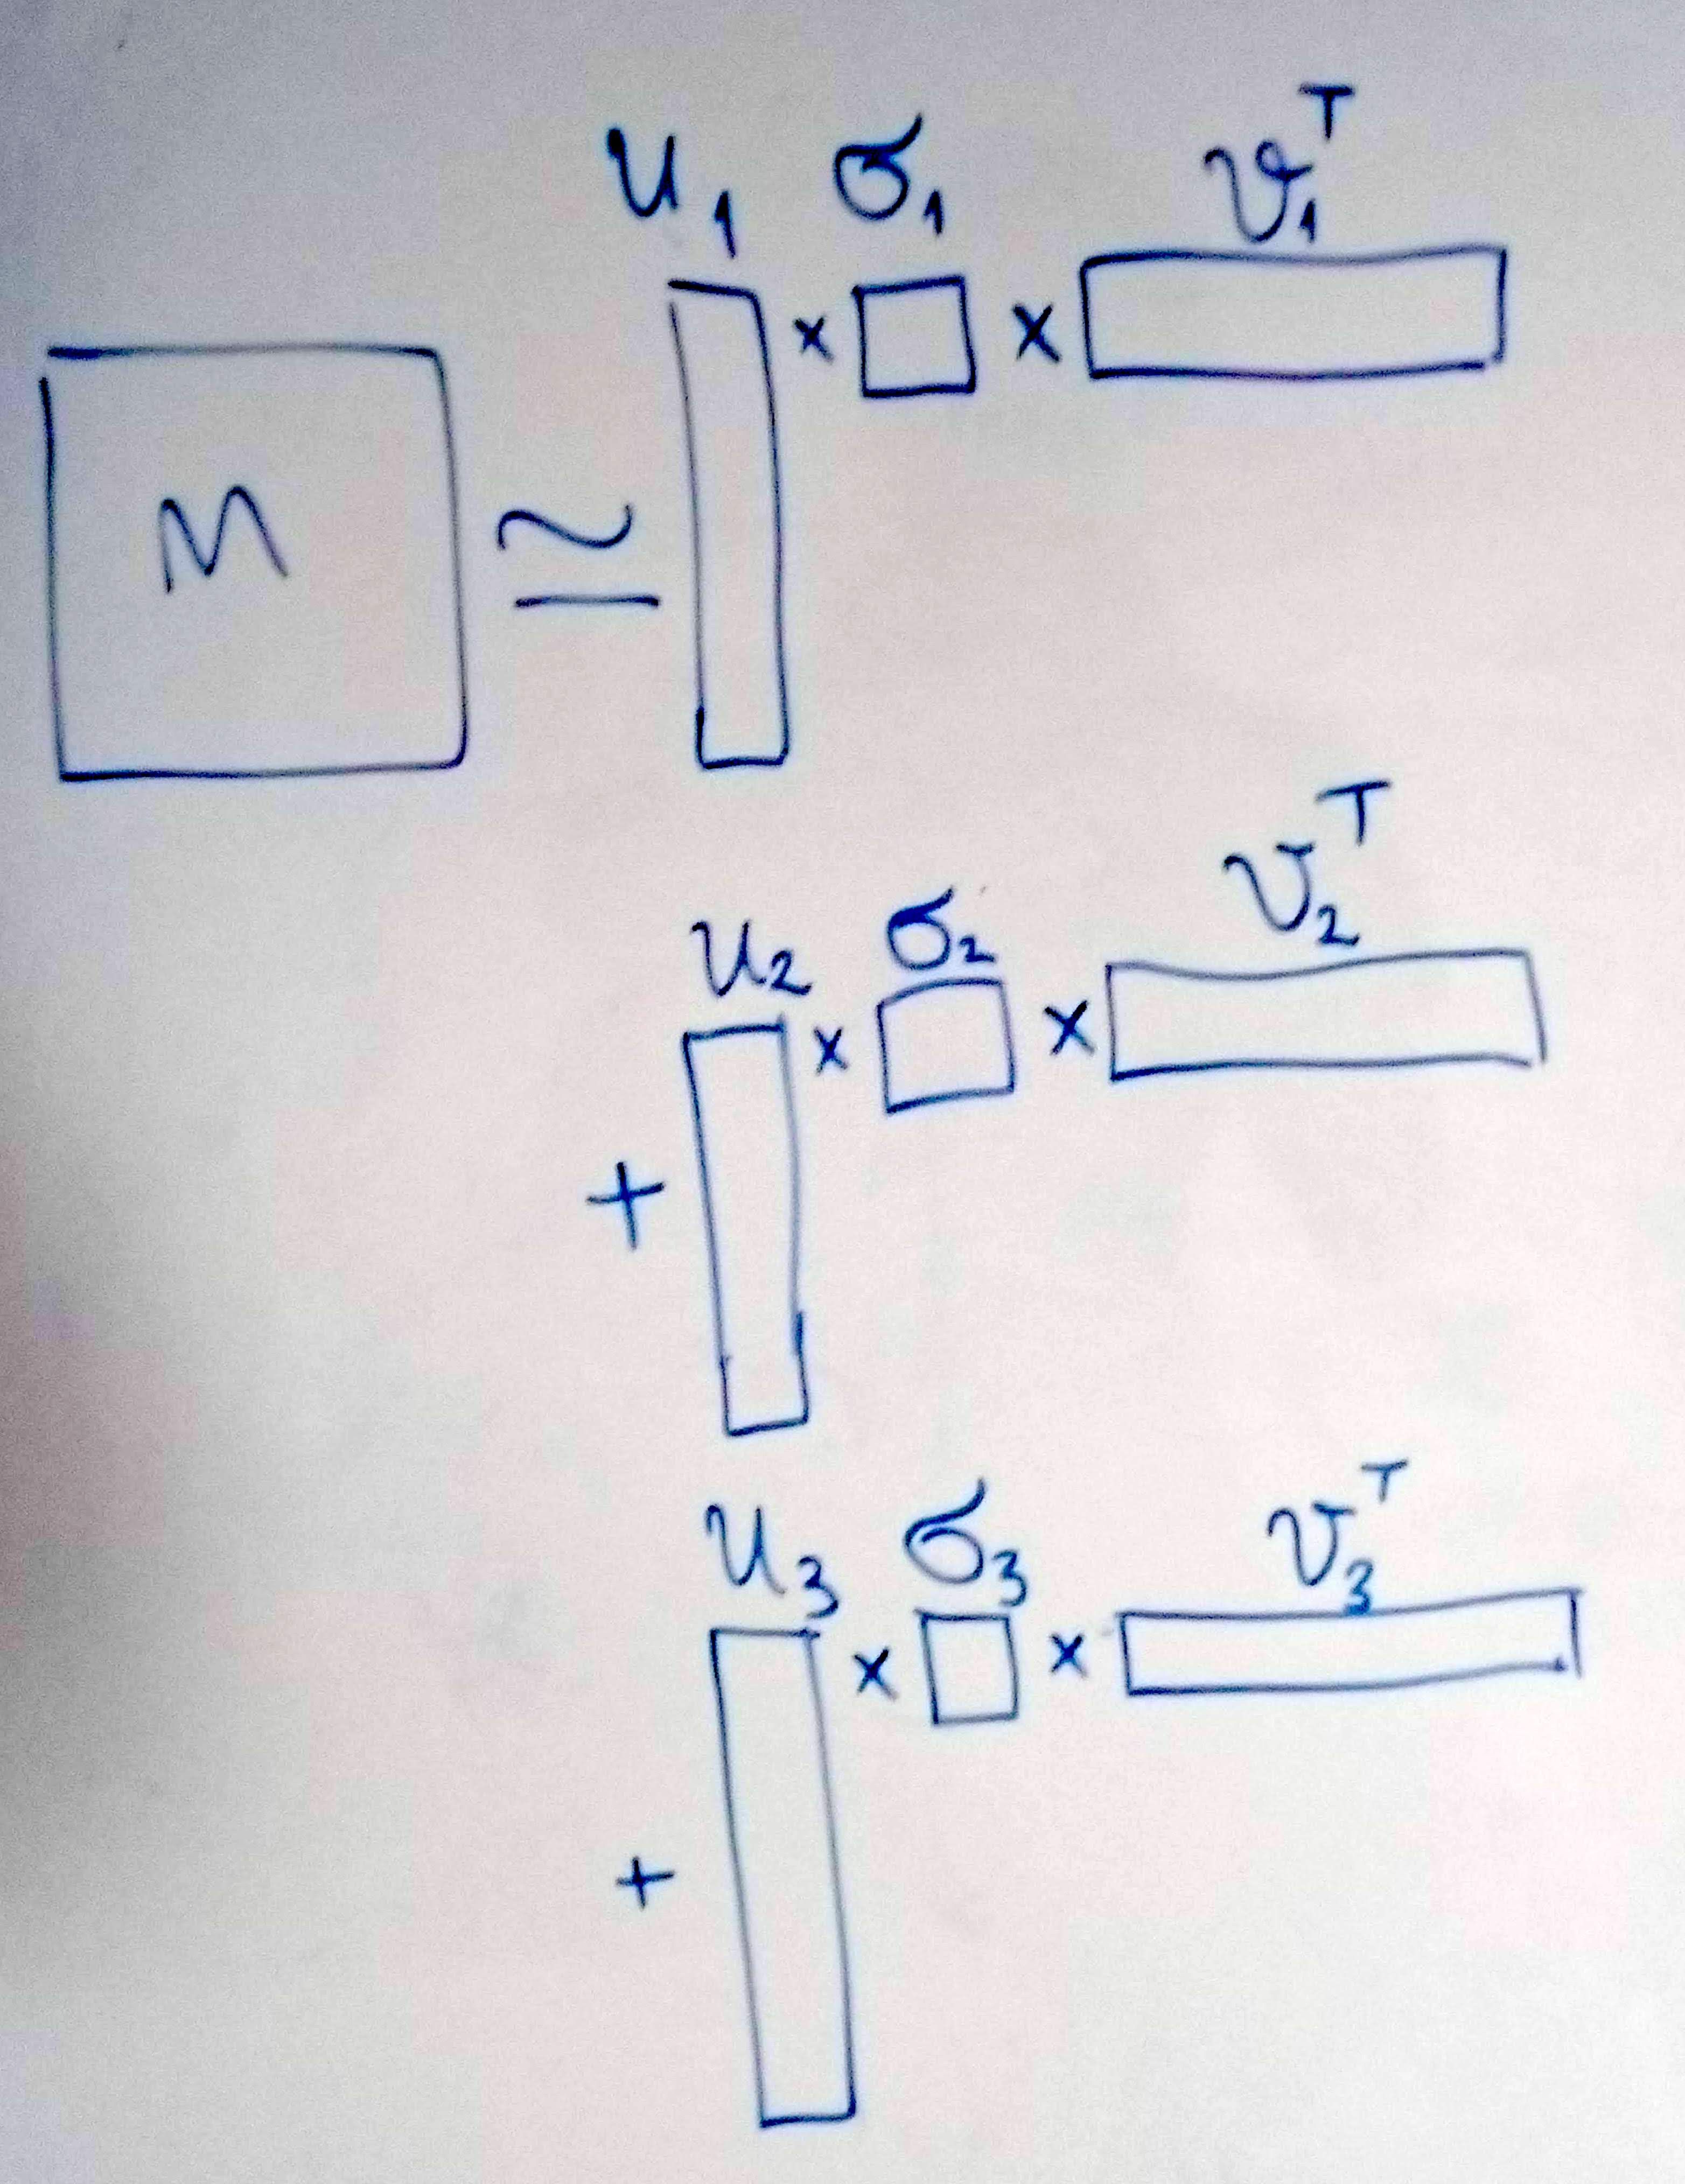

In [30]:
print('Figure 8')
print("\n")
Image(filename='img/separable_matrices.jpg', width=500, height=400) 



#### $$ \underline{\underline{M}} = \underline{\underline{U}} * \underline{\underline{\Sigma}} * \underline{\underline{V}} ^{T} $$

* where M is our original (m, n) data matrix - m rows, n columns; m documents, n terms
* U is a (m, r) matrix - m documents and r *concepts*
* $ {\Sigma} $ is a *diagonal* (r,r) matrix - all values except those in the diagonal are zero. (But what do the non-zero values represent? Why r*r? 
* V is a (n,r) matrix - n terms, r concepts - what shape will it have when transposed?


If we were to decompose this to 5 components, this would look something like this:

### $$ M_{trunc} =  \sum_{i}^{5} {\sigma}_{i}\underline{u}_{i} {\otimes} \underline{v}_{i}^T  $$

where there would be originally r number of u vectors; 5 singular values and n $v^{T}$ vectors. 


#### Code: Scikit-Learn Implementation

Thanks to Scikit-Learn, TruncatedSVD objects are functionally extremely similar to the previous data-transformation objects you've seen before, which makes implementation very straightforward.



Let's take the first 20 documents of our newsgroups data. We're not gonna get the same clear-cut distinctions as in the example in the Intuition section, but we're focussing more on the Python implementation here. We've vectorized our data (represented text as vectors) below:

In [18]:
print('Number of columns  in our dataset is:', len(sample_exp.columns))
sample_exp
# QUESTION: What does tf-idf stand for? 
#
# QUESTION: What does the idf part measure, intuitively?
#
# STRETCH: what's the full formula for tf-idf?  (either the classic formula or the sklearn one will do)
#

Number of columns  in our dataset is: 325


,able,absolute,acceleration,access,actually,add,addition,agree,almost,already,...,worse,worth,would,writers,writes,writing,wrong,year,years,yet
0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.148713,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.122926,0.000000
1,0.000000,0.000000,0.132307,0.000000,0.00000,0.218730,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.096939,0.10743,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.10743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.091326,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.156392,...,0.000000,0.00000,0.000000,0.000000,0.092476,0.000000,0.000000,0.000000,0.000000,0.156392
5,0.000000,0.000000,0.000000,0.072726,0.00000,0.000000,0.000000,0.080597,0.000000,0.000000,...,0.000000,0.00000,0.085339,0.000000,0.190631,0.000000,0.000000,0.072726,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.073530,0.043479,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.131237,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.048395,0.000000,0.054052,0.091412,0.082485,0.082485,0.000000,0.000000


Here we have taken the most important words and represented what TF-IDF score they have. We've filtered out words under a certain idf score, so we got rid of a lot of words that don't convey any meaning. It's worth noting that this method is generalizable to any kind of real-valued matrix (real as in the numbers in the cells are real, and not complex or imaginary, numbers). 


The nature of Truncated SVD is such that we can choose the number of final components, whereas a full SVD would explain the entirety of the variance in the data. We're aiming to explain our data (relatively) accurately but with fewer features, so reducing the number of features from 325 to 100 is a significant step in that direction. 


In [19]:
svd = TruncatedSVD(n_components=10, n_iter=100, random_state=42)

sample_decomp = svd.fit_transform(sample_exp.to_numpy())
Sigma = svd.singular_values_
U = sample_decomp/Sigma
V_T = svd.components_

<AxesSubplot:>

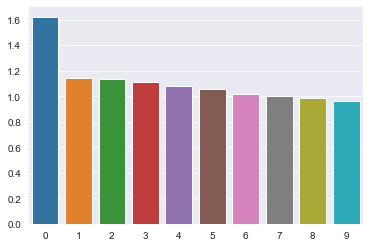

In [20]:
sns.barplot(x=list(range(len(Sigma))), y = Sigma)

In [23]:
V_T.shape

(20, 325)

In [24]:
# We're going to do the full, un-truncated SVD, for illustrative purposes
# unfortunately TruncatedSVD (a wrapper function) only accepts n_components
# less than n_features, so we'll be using randomized_svd, the OG SVD sklearn 
# function.
U, Sigma, V_T = randomized_svd(M = sample_exp.to_numpy(), n_components=20,
                    n_iter= 200, random_state=12345, transpose=False)

U[0]

array([ 0.2304242 , -0.33009207,  0.22222462,  0.44955878,  0.03204524,
        0.03402955,  0.0450456 , -0.0709719 , -0.03415876, -0.42590694,
       -0.01462313,  0.07210528, -0.0663933 , -0.09524134,  0.12120548,
        0.04769738, -0.12986894, -0.03098186, -0.2016688 , -0.5479859 ])

In [25]:
Sigma

array([1.62270596, 1.14152868, 1.1307284 , 1.11272151, 1.07953239,
       1.05712135, 1.0145306 , 0.99992768, 0.98285807, 0.9639876 ,
       0.93353336, 0.92611605, 0.91671171, 0.89872399, 0.87999671,
       0.86742211, 0.82598611, 0.79101092, 0.77016585, 0.73114533])

In [26]:
print("U           - ",U.shape)
print("Sigma       - ",Sigma.shape)
print("V_transpose - ",V_T.shape)

U           -  (20, 20)
Sigma       -  (20,)
V_transpose -  (20, 325)


In [27]:
U

array([[ 2.30424196e-01, -3.30092074e-01,  2.22224616e-01,
         4.49558777e-01,  3.20452388e-02,  3.40295485e-02,
         4.50455986e-02, -7.09718961e-02, -3.41587590e-02,
        -4.25906940e-01, -1.46231345e-02,  7.21052821e-02,
        -6.63933000e-02, -9.52413370e-02,  1.21205478e-01,
         4.76973759e-02, -1.29868943e-01, -3.09818610e-02,
        -2.01668799e-01, -5.47985905e-01],
       [ 1.95077155e-01,  2.10601254e-01,  3.86450474e-01,
        -7.75207654e-02, -2.58400149e-01, -8.19916416e-02,
         4.89693366e-01, -1.35384506e-01,  9.16101691e-04,
         1.15143550e-01, -1.40985293e-01, -3.81243735e-02,
         2.85052261e-02, -1.23177648e-01, -2.49589172e-01,
         1.65558845e-01, -2.96710987e-01,  2.37681961e-01,
        -3.47997020e-01,  1.57180594e-01],
       [ 2.88059817e-01,  1.60352759e-02,  7.59939515e-02,
        -1.32851500e-01, -2.72366800e-01, -1.07135654e-01,
        -3.48739621e-01,  2.75404287e-01, -6.17950175e-02,
        -1.93632772e-01,  1.6

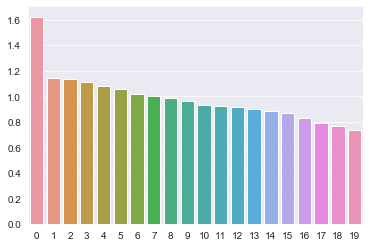

In [39]:
#What do you notice about the values in Sigma? Do they conform to what you expected singular values to be like?

sns.barplot(x=list(range(len(Sigma))), y=Sigma)

In [29]:
# and ofc we could get part of our original dataset back
low_dim_data = np.matmul(np.matmul(U, Sigma), V_T)
low_dim_data.shape

(325,)

In [30]:
sample_exp.to_numpy().shape

(20, 325)

In our current matrix, we are representing **documents** via **words**. When doing SVD, we assume that within all that jumble of words, across all documents, there must be some set of **concepts** (or topics, if you prefer) and we would prefer to represents the documents through those concepts instead. This will simplify our data and summarize its properties. Let's do TruncatedSVD but this time with all of the vectorized data.

In [31]:
#now we reduce the dimensionality of our tfidf array using PCA, to two dims
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

skl_decomp_obj = TruncatedSVD(n_components=100, n_iter=100, random_state=42)

tfidf_lsa_data = skl_decomp_obj.fit_transform(tfidf_train_df)


In [32]:
# and our data's shape has now been drastically changed
tfidf_lsa_data.shape

(11314, 100)

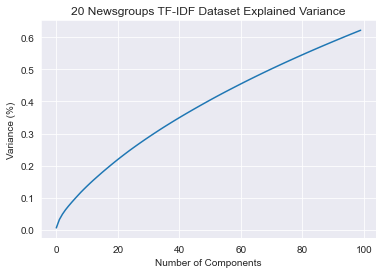

In [33]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(skl_decomp_obj.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('20 Newsgroups TF-IDF Dataset Explained Variance')
plt.show()

So, with 100 components we've managed to account for about a quarter of the variance in our data. This is after we brought it down from 1684 dimensions, so that's a lot of compression. Below I've run a gridsearchCV on a two logistic regression models, on with standard tf-idf data and one without it, to compare. 

In [34]:
logreg_pca = LogisticRegression()
logreg     = LogisticRegression()
logreg_param_grid = [{'penalty':['l1', 'l2']},
                 {'tol':[0.0001, 0.0005, 0.001]}]

# knn_pca.fit(pca_data, y_train)
# knn.fit(x_train_scaled, y_train)

grid_lsa_log = GridSearchCV(estimator=logreg_pca,
                        param_grid=logreg_param_grid, 
                        scoring='accuracy', cv=5,
                        n_jobs=6)

grid_log = GridSearchCV(estimator=logreg,
                        param_grid=logreg_param_grid, 
                        scoring='accuracy', cv=5,
                        n_jobs=6)


best_lsa_logreg = grid_lsa_log.fit(tfidf_lsa_data, y_train).best_estimator_
best_reg_logreg = grid_log.fit(tfidf_train_df, y_train).best_estimator_

In [35]:
print("ROC AUC of optimized Logistic Regression on validation data with decomposed data is :", best_lsa_logreg.score(tfidf_lsa_data, y_train))
print("ROC AUC of optimized Logistic Regression with standard validation data is :", best_reg_logreg.score(tfidf_train_df, y_train))

ROC AUC of optimized Logistic Regression on validation data with decomposed data is : 0.4604030404808202
ROC AUC of optimized Logistic Regression with standard validation data is : 0.5424253137705498


The drop in performance is significant, but you can work this into an optimization pipeline and tweak the number of latent components.  
Of course, this is multi-label classification, so it would be best to visualize this with a confusion matrix. Our results look significantly better when you consider the random chance probability given 20 news categories. 

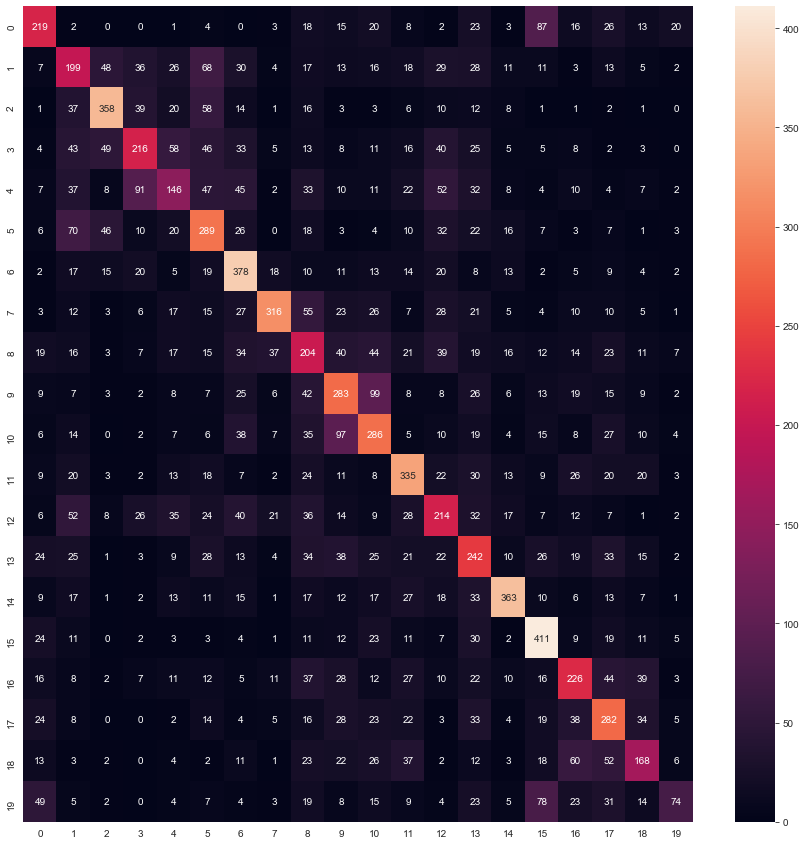

In [53]:
logreg_group_pred = best_lsa_logreg.predict(tfidf_lsa_data)
plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix(y_train, logreg_group_pred ), 
            annot=True, fmt='.4g');

In [54]:
from mpl_toolkits.mplot3d import Axes3D


I've included below some visualizations of the transformed data, just for the worth of the example code and to how the data looks when plotted along these componensts.

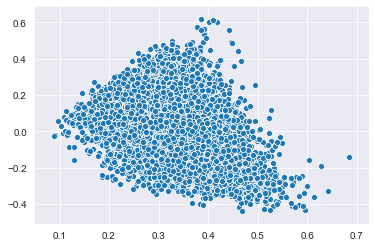

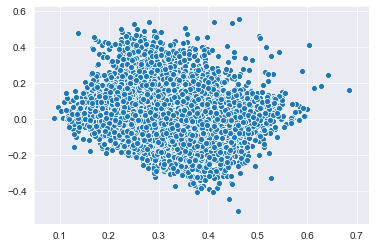

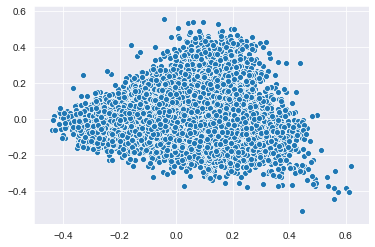

In [58]:
sns.scatterplot(tfidf_lsa_data[:,0], tfidf_lsa_data[:,1])
plt.show();
sns.scatterplot(tfidf_lsa_data[:,0], tfidf_lsa_data[:,2])
plt.show();
sns.scatterplot(tfidf_lsa_data[:,1], tfidf_lsa_data[:,2])
plt.show();


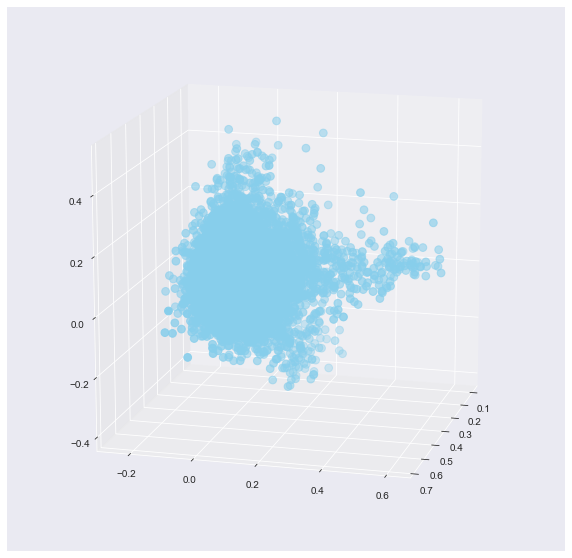

In [59]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tfidf_lsa_data[:,0], tfidf_lsa_data[:,15], tfidf_lsa_data[:,9], c='skyblue', s=60)
ax.view_init(15, 15)
plt.show()